# Daymet V4 - Data Access and Subsetting

*Author:  ORNL DAAC*
<br>
*Date: August 31, 2021*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/):  uso@daac.ornl.gov*

##### Keywords:  ORNL DAAC, Daymet, THREDDS, OPeNDAP, Earthdata, `pydap`

## Overview

This tutorial will demonstrate how to programatically discover, access, subset, and download  [Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840).  

The **Daymet** datset provides long-term, gridded estimates of daily weather data and standard climatologies interpolated and extrapoloated from ground-based surface weather observations.  Daymet weather variables include: 

DAYMET VARIABLES:

| Variable | Description (units)                           
|:---------|:---------------------------------------:|
| tmax     | Daily maximum 2-meter air temperature (°C)
| tmin     | Daily minimum 2-meter air temperature (°C)
| prcp     | Daily total precipitation (mm/day)
| srad     | Incident shortwave radiation flux density (W/m2)
| vp       | Water vapor pressure (Pa)
| swe      | Snow water equivalent (kg/m2)
| dayl     | Duration of the daylight period (seconds/day)

Daily files are produced on a **1km x 1km** spatial grid and distributed in a multidimensional, netCDF, file format. Daymet data is available for continenal North America (na), with Hawaii (hi), and Puerto Rico (pr) as separate data files.

![title](images/Daymet_V4_Annual_Climatology_Fig1.png)

## Source Data
The [Daymet Website](https://daymet.ornl.gov) provides information about and access methods for the Daymet datasets under the [Get Data](https://daymet.ornl.gov/getdata) tab.

At the time of this webinar (Aug, 2021) the Daymet V4 data files are available from both on-prem resouces at the ORNL DAAC and NASA Earthdata Cloud.  Cloud-based storage and access will eventually replace on-prem access.  

Add THREDDS Info here

Add OPeNDAP Info here
* Support for [OPeNDAP](https://www.opendap.org/) (via the netCDF4 library or Pydap), lets us access large datasets over HTTP.

### Requirements
* Python 3.7 or higher
* geopandas and dependencies
* pydap
* xarray
* rasterio
* shapely

In [1]:
#Running from pyenv, Conda, activate hyrax_daymet
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pyproj
import datetime as dt 
from rasterio.features import Affine
from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import rioxarray
import shapely
import rasterio
from shapely.geometry import mapping

In [3]:
print("This Notebook was produced with the following versions")
print("geopanda version   : ", gpd.__version__)
print("pyproj version     : ", pyproj.__version__)
print("rioxarray version  : ", rioxarray.__version__)
print("xarray version     : ", xr.__version__)
print("shapely            : ", shapely.__version__)
print("rasterio           : ", rasterio.__version__)

This Notebook was produced with the following versions
geopanda version   :  0.10.2
pyproj version     :  3.3.0
rioxarray version  :  0.10.3
xarray version     :  2022.3.0
shapely            :  1.8.0
rasterio           :  1.2.10


In [4]:
!python --version

Python 3.9.12


***
***

## Tutorial
In this tutorial we're going to demonstrate how to programmatically discover and download a subset of Daymet data using the bounding box of a projected polygon file as a region of interest.  We'll then clip the subset using the same polygon.

We'll start by demonstrating how we can search for Daymet files of interest.  Steps we'll explore are: 
1.  Establish a polygon parameters to use as a boundary file for subsetting Daymet Data
1. Leverage the Daymet DOI and NASA's Common Metadata Repository (CMR) API to search for Daymet data within our spatial and temporal region of interest
1. Download subsets of data via on-prem THREDDS or NASA Earthdata Cloud
1. Clip the subset to our polygon of interes

### Step 1.  Polygon Boundary Area Parameters for Subsetting

We will use a boundary of the [Great Smokey Mountain National Park (GRSM)](https://www.nps.gov/grsm/planyourvisit/maps.htm) to demonstrate the spatial subsetting process. Let's read the boundary file first.

We'll use Python's [GeoPandas](https://geopandas.org/index.html) to explore the polygon file

* **`Geopandas`** is open-sourced library and enables the use and manipulation of geospatial data in Python. It extends the common datatype used in pandas to allow for the many and unique geometric operations

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

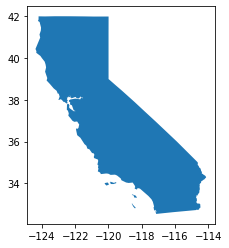

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
ca_poly = gpd.read_file('bnds/California.shp')
ax = ca_poly.plot() # boundary file of the Great Smokey Mountains National Park

ca_poly.crs  # Lists the coordinate reference system (crs)

As we see above, the boundary file is in the `EPSG:4269` projection. Daymet is natively in `lambert_conformal_conic (LCC)` system. 

In [6]:
# Let's store the geographic bounding box of the Park boundary for the OPeNDAP searching inputs below
#xy = grsm_poly.crs.area_of_use.bounds 
#xy
ca_poly_4269 = ca_poly.to_crs(epsg=4326)
xy = ca_poly_4269.bounds # bound of polygon in lat, lon 
xy

,minx,miny,maxx,maxy
0,-124.392636,32.535783,-114.125228,42.002192


In [7]:
xy = ca_poly_4269.bounds.values.tolist()[0] # We'll need this as a Python list to server as a subsetting parameter
print(xy)

[-124.39263575019409, 32.53578253612507, -114.1252281747415, 42.002192463378705]


We can now reproject the geopandas object (`ca_poly`) to LCC using the **`geopandas`** **`to_crs`** .

In [8]:
#defining Daymet proj
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
ca_poly_lcc = ca_poly.to_crs(daymet_proj) # to_crs re-projects from 4269 to LCC
ca_poly_lcc.crs

<Derived Projected CRS: +proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.31424 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

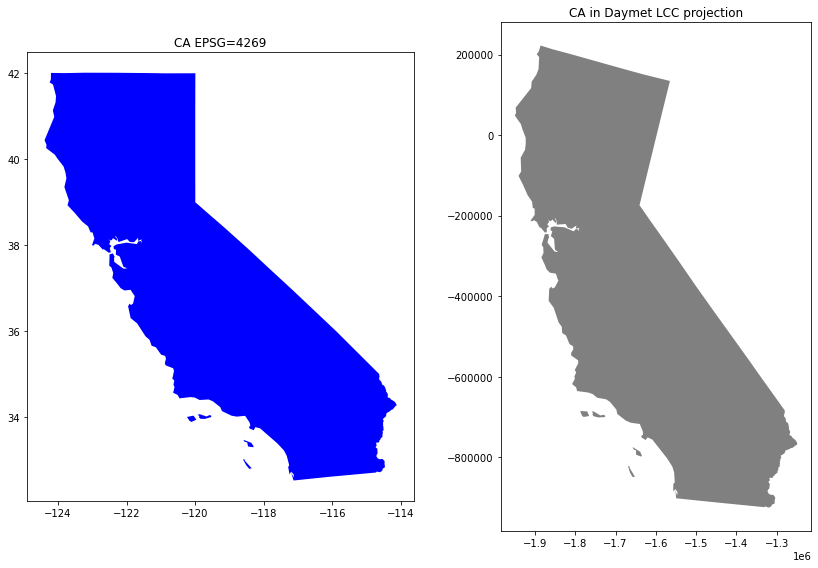

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ca_poly.plot(ax=ax1, facecolor='blue');
ax1.set_title("CA EPSG=4269");
ca_poly_lcc.plot(ax=ax2, facecolor='grey');
ax2.set_title("CA in Daymet LCC projection");
plt.tight_layout()

These are the bounding minx, miny, maxx, and maxy in the LCC Projection 

In [10]:
lccbounds = ca_poly_lcc.bounds # Bounds in LCC projection
print('Projected bounding box of the California polygon file in LCC projection')
print('----------------------------------------------------------------------------------')
lccbounds

Projected bounding box of the California polygon file in LCC projection
----------------------------------------------------------------------------------


,minx,miny,maxx,maxy
0,-1.949774e+06,-924691.393575,-1.249285e+06,222385.260663


### Step 2. Leveraging NASA's Common Metadata Repository (CMR) API to search NASA Earthdata for Daymet data within a spatial and temporal region of interest

#### A little background ...

All data archived at the ORNL DAAC is assigneed a permanent Digital Object Identify [DOI](https://www.doi.org/).  

The [Daymet V4 Daily](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840) data DOI, **doi.org/10.3334/ORNLDAAC/1840**, is found as part of its citation:

<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S. Kao, and B.E. Wilson. 2020. Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1840
</div>


**To start, let's look at ORNL DAAC holdings of the Daymet V4 Daily Data available through a Thredds Data Server**

[Daymet V4 Daily Data in the ORNL DAAC THREDDS Data Server](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1840/catalog.html)

##### Daymet in NASA's EarthData Cloud

At the time of this webinar, Daymet data is archived at the ORNL DAAC (on-prem) **AND** now at [NASA's EarthData Cloud](https://earthdata.nasa.gov/esds/cloud).

We'll demonstrate how to use the Daymet dataset DOI to obtain the NASA EarthData's unique ID (called the `Concept ID`) for the **Daymet V4 Daily** data using NASA's [CMR API](https://cmr.earthdata.nasa.gov/search).  With this information, we can search all NASA Earthdata holdings for relevant data files (granules) based on our spatial area (e.g. grsm_poly_lcc) and time period of interest.

Search NASA Earthdata Holdings based on...
* DOI
* ConceptID
* Area of Interest
* Time Range of Interest

##### Obtaining the Daymet V4 Daily data *Concept ID*
Using Python's **`requests`** library, we will build and provide the URL `doisearch` to search **NASA's Metadata Repository** to acquire the **concept_id** unique to the Daymet V4 Daily data in NASA's Cloud holdings.  We'll use the **concept_id** in a next step when we search NASA Cloud Holdings for our spatial and temporal area of interest.

* **`requests`** is a simple HTTP libray for Python.  It allows you to easily send HTTP requests. 


In [11]:
import requests
daymet_doi = '10.3334/ORNLDAAC/1840' # define the DOI as the variable `daymet_doi`
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doisearch = cmrurl + 'collections.json?doi=' + daymet_doi # 
print('Earthdata Metadata for DaymetV4 Daily --> ' , doisearch)

Earthdata Metadata for DaymetV4 Daily -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1840


In [12]:
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0]
#print(collection)
concept_id = collection['id']
print('NASA Earthdata Cloud-based Concept_ID --> ' , concept_id)

NASA Earthdata Cloud-based Concept_ID -->  C2031536952-ORNL_CLOUD


`C2031536952-ORNL_CLOUD` is the unique NASA-given concept ID for the Daymet dataset. We can use this to search relevant granules and their names. 

##### Searching for Daymet Files 
Daymet data files (or granules) are natively in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (each for dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for US, PR, HI). We will first search for all the granules in the area of interest (i.e., GRSM) and the time period.  Daymet filenames can be used to identify the files from continental North America (`*_na_*.nc`). The files from Puerto Rico and Hawaii are named as (`*_pr_*.nc`) and (`*_hi_*.nc`) respectively. For this tutorial, we will download precipitation data (`prcp`) for the year 2010-2020.

For our search, we'll use the Bounding Box of the Great Smokey Mountains National Park that we defined above.

Let's also define a `time range` in a format that the API recognizes and the Daymet `variable` of interest :

In [13]:
import datetime as dt 

start_date = dt.datetime(2010, 1, 1) # specify your own start date
end_date = dt.datetime(2011, 1, 1)  # specify your end start date
#updated to one day for Hyrax testing on Dec 09, 2021
#start_date = dt.datetime(2010, 2, 1) # specify your own start date
#end_date = dt.datetime(2010, 2, 1)  # specify your end start date

print(start_date,end_date,sep='\n')

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

print('\n')

#var = 'prcp' # select your own variable
var = 'tmax' # select your own variable

print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range :     ', temporal_str)
print('Daymet variable :', var)
print('bounding box :   ', xy)
print('concept ID :     ', concept_id)
print('cmr url :        ', cmrurl)

2010-01-01 00:00:00
2011-01-01 00:00:00


Variables we have defined to pass to the CMR API
-----------------------------------------------
time range :      2010-01-01T00:00:00Z,2011-01-01T00:00:00Z
Daymet variable : tmax
bounding box :    [-124.39263575019409, 32.53578253612507, -114.1252281747415, 42.002192463378705]
concept ID :      C2031536952-ORNL_CLOUD
cmr url :         https://cmr.earthdata.nasa.gov/search/


In [14]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy))
print(granulesearch)                

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2031536952-ORNL_CLOUD&page_size=1000&temporal=2010-01-01T00:00:00Z,2011-01-01T00:00:00Z&bounding_box[]=-124.39263575019409,32.53578253612507,-114.1252281747415,42.002192463378705


##### Searching NASA's Earthdata holdings
Using Python's **`requests`** library, we can provide the URL `granulesearch` created above to search **NASA's Earthdata Metadata** holdings for Daymet data that fit our spatial, temporal, and variable request.

In [15]:
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']  
granule_names = []
for g in granules:
    granule_name = g['title']
    if var in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc
Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc


Now the array `granule_names` contains the names of all the granules we need.

**Note:** A typical Daymet V4 daily file has the name **daymet_v4_daily_area_var_year.nc**.  The beginning of the filename (**"Daymet_Daily_V4."**) is specific to the cloud-based naming convention and because we are searching CMR, the cloud-based files will be discovered.  We'll strip out (**"Daymet_Daily_V4."**) below when we access the files from the on-prem ORNL DAAC's OPeNDAP client through THREDDS.

### Step 3. Downloading subset data through ORNL DAAC THREDDS ( or NASA Earthdata Cloud )
Daymet data is available through ORNL DAAC's THREDDS server AND the NASA EarthData Cloud. We will use this to download the polygonal subset.

We'll use Pythons **`pydap`** library and the bounding box of the polygon file.

* **`pydap`** can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally.  Data can be downloaded on-the-fly as needed.

Pydap Xarray open_dataset *Parameters*
* **[xarray.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)** 






In [16]:
# THIS IS ACCESSING DAYMET DAILY DATA in NGAP HYDRAX via OPeNDAP.  
# for loop based on response granules eg.) Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc, Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc 

from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import time

username = "xxxxx" # Earthdata URS Login (only needed for NGAP Hyrax) Get account here https://urs.earthdata.nasa.gov/
password= "XXXXXXXXXX"

hyrax_url = 'https://opendap.earthdata.nasa.gov/collections/C2031536952-ORNL_CLOUD/granules/'

session = setup_session(username, password, check_url=hyrax_url)  

before = time.time()
cnt = 0 
for g_name in granule_names:
    print('granule_name ---->', g_name)
    #granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4.','') #The name suffix is needed for cloud file name
    granule_dap = hyrax_url + g_name 
    print(granule_dap)
    
    hyrax_ds = open_url(granule_dap, session=session)
    ds = xr.open_dataset(xr.backends.PydapDataStore(hyrax_ds), decode_coords="all")
    
    dummy=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    #dummy=ds['prcp'].sel(x=slice(1386957,1470587), y=slice(-565105,-612937))
    if cnt==0:
        tmax_h = dummy
    else:
        tmax_h = xr.concat([tmax_h, dummy], dim="time")
    
    cnt += 1

# save to netcdf
tmax_h.to_netcdf(var + '_cali_hyrax_subset.nc')
print("Processing Time: ", time.time() - before, 'seconds')

granule_name ----> Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc
https://opendap.earthdata.nasa.gov/collections/C2031536952-ORNL_CLOUD/granules/Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc
granule_name ----> Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc
https://opendap.earthdata.nasa.gov/collections/C2031536952-ORNL_CLOUD/granules/Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc


OverflowError: Python int too large to convert to C long

In [17]:
# THIS IS ACCESSING DAYMET DAILY DATA in NGAP HYDRAX via OPeNDAP.  
# for loop based on response granules eg.) Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc, Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc 

from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import time

username = "xxxxx" # Earthdata URS Login (only needed for NGAP Hyrax) Get account here https://urs.earthdata.nasa.gov/
password= "XXXXXXX"

hyrax_url = 'https://opendap.earthdata.nasa.gov/collections/C2031536952-ORNL_CLOUD/granules/'

session = setup_session(username, password, check_url=hyrax_url)  

before = time.time()
cnt = 0 
for g_name in granule_names:
    print('granule_name ---->', g_name)
    #granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4.','') #The name suffix is needed for cloud file name
    granule_dap = hyrax_url + g_name 
    print(granule_dap)
    
    hyrax_ds = open_url(granule_dap, session=session)
    ds = xr.open_dataset(xr.backends.PydapDataStore(hyrax_ds), decode_coords="all")
    
    subset=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    subset.to_netcdf(g_name.replace('Daymet_Daily_V4.','CAsubset_'))
    
    #if cnt==0:
    #    tmax_h = dummy
    #else:
    #    tmax_h = xr.concat([tmax_h, dummy], dim="time")
    
    #cnt += 1

# save to netcdf
#tmax_h.to_netcdf(var + '_cali_hyrax_subset.nc')
#granule_name ----> Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc
#subset.to_netcdf(g_name.replace('Daymet_Daily_V4.','CAsubset_'))
print("Processing Time: ", time.time() - before, 'seconds')

granule_name ----> Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc
https://opendap.earthdata.nasa.gov/collections/C2031536952-ORNL_CLOUD/granules/Daymet_Daily_V4.daymet_v4_daily_na_tmax_2010.nc
granule_name ----> Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc
https://opendap.earthdata.nasa.gov/collections/C2031536952-ORNL_CLOUD/granules/Daymet_Daily_V4.daymet_v4_daily_na_tmax_2011.nc
Processing Time:  137.68494772911072 seconds


##### Let's take a look at the Daymet Temperature Subset for 2011

In [18]:
subset

<xarray.DataArray 'tmax' (time: 365, y: 1147, x: 700)>
[293058500 values with dtype=float32]
Coordinates:
  * y                        (y) float32 2.22e+05 2.21e+05 ... -9.24e+05
    lon                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
  * time                     (time) datetime64[ns] 2011-01-01T12:00:00 ... 20...
    lat                      (y, x) float32 ...
  * x                        (x) float32 -1.949e+06 -1.948e+06 ... -1.25e+06
Attributes:
    long_name:     daily maximum temperature
    units:         degrees C
    cell_methods:  area: mean time: maximum

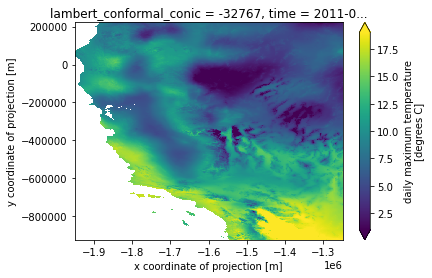

In [19]:
import matplotlib.pyplot as plt
tmax_ca = subset.isel(time=6) # isel = xarray index selection (python index start from 0, so day 7) 
ax = plt.subplot()
tmax_ca.plot(ax=ax, robust=True)
# Note xarray uses dimension and attribute information image - time:2010-01-07, projection is recognized

<AxesSubplot:title={'center':'lambert_conformal_conic = -32767, time = 2011-0...'}, xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

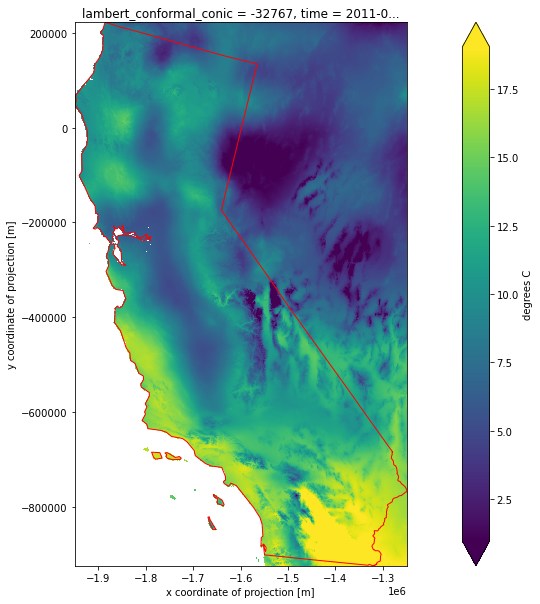

In [20]:
import matplotlib.pyplot as plt
tmax_ca = subset.isel(time=6)
fig, ax = plt.subplots(figsize = (20,10))
tmax_ca.plot(ax=ax, robust=True, cbar_kwargs={'label': 'degrees C'})
ca_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

### Step 4. Clipping the subset area by polygon
In this step, we demonstrate how to clip the subset to our polygon of interest.  We'll use Python's *rasterio* library.

* **`rasterio`** provides many capabilities found in GDAL

First, we'll map the subset precipitation data matrix to real world coordinates using the **'translation'** and **'scale'** methods of **'Affine'**.

In [21]:
from rasterio.features import Affine
res = 1000 # daymet spatial resolution is 1km x 1km
transform = Affine.translation(min(subset.x).values - res / 2, min(subset.y).values - res / 2) * Affine.scale(res, res)
transform

Affine(1000.0, 0.0, -1949750.0,
       0.0, 1000.0, -924500.0)

In [22]:
from rasterio.features import geometry_mask
ca_mask = geometry_mask(ca_poly_lcc.geometry, out_shape=(len(subset.y), len(subset.x)), transform=transform, invert=True)
polymask = xr.DataArray(ca_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1)) 
tmax_masked = subset.where(polymask == True)
# write out to a netCDF file
tmax_masked.to_netcdf(var + '_subset_poly.nc')

Now let's plot the subset for the day

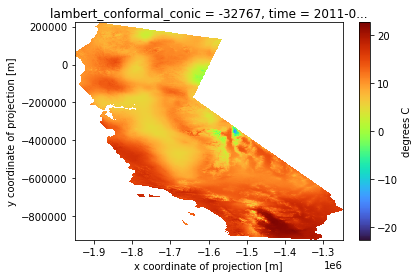

In [23]:
import matplotlib.pyplot as plt
tmax_1 = tmax_masked.isel(time=6)
ax = plt.subplot()
tmax_1.plot(ax=ax, cmap="turbo", cbar_kwargs={'label': 'degrees C'})

<AxesSubplot:title={'center':'lambert_conformal_conic = -32767, time = 2011-0...'}, xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

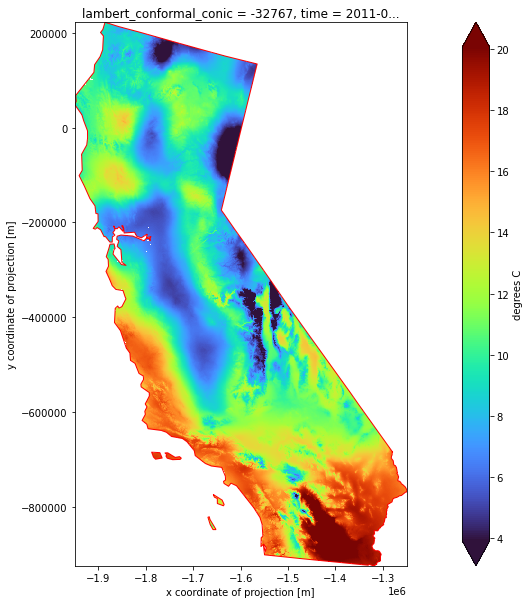

In [24]:
import matplotlib.pyplot as plt
tmax_1 = tmax_masked.isel(time=6)
fig, ax = plt.subplots(figsize = (20,10))
tmax_1.plot(ax=ax, robust=True, cmap="turbo", cbar_kwargs={'label': 'degrees C'})
ca_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

#### Saving to a GeoTIFF
The subset data can also be clipped by a polygon of interest and converted to GeoTiff using the rioxarray and shapely libraries.

* **`rioxarray`** is an extention of xarray.  It can be used to clip, merge, and reproject rasters
* **`shapely`** is a Python package for manipulation and analysis of planar geometery objects

In [ ]:
import rioxarray
from shapely.geometry import mapping
#prcp_sub = rioxarray.open_rasterio(var + '_subset_poly.nc', decode_coords="all")
prcp_sub = rioxarray.open_rasterio(var + '_tdssubset.nc', decode_coords="all", decode_times=False)
prcp_clip = prcp_sub.prcp.rio.clip(grsm_poly_lcc.geometry.apply(mapping), grsm_poly_lcc.crs, invert=False, from_disk=True)

# saving one time step to geotiff
prcp_clip_day6 = prcp_clip.isel(time=6)
prcp_clip_day6.rio.to_raster("prcp_clip_day6.tif")